# Import libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re
import string
from matplotlib import pyplot as plt 
import spacy
import pickle
from spacy.matcher import Matcher
from spacy.tokens import Doc, Span
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from collections import Counter

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,learning_curve
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif,SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# load nlp pre-trained model 
# choose 'en_core_web_lg': larger model that has been trained on a larger and diverse set of text data
nlp = spacy.load('en_core_web_lg')
matcher = Matcher(nlp.vocab)     
stemmer = PorterStemmer()

# Data Analysis

- Create a new target 'order status' which contains labels {1,0}
- I define: tags 'where-is-my-order','order-confirmation-not-received','missing-items' belong to 'order status'

In [3]:
# open json file
with open('technical_test_data.json') as f:
    data = json.load(f)    
df = pd.json_normalize(data)
df = df[['Description','tags']]
df = df.explode("tags")
# row has these tags => remove
tags_tobe_removed = ['ticket','open-ticket','field-1456','category-1']
df = df[~df['tags'].isin(tags_tobe_removed)]
# all original labels and their frequency 
tags_counts = df['tags'].value_counts().to_dict()
# original tags are classified into order status : Yes (customers ask about their 'order status')
order_status = ['where-is-my-order','order-confirmation-not-received','missing-items']
# add new column 'order_status' which contains binary values : 1 and 0 
df['order_status'] = df['tags'].isin(order_status).astype(int)
    

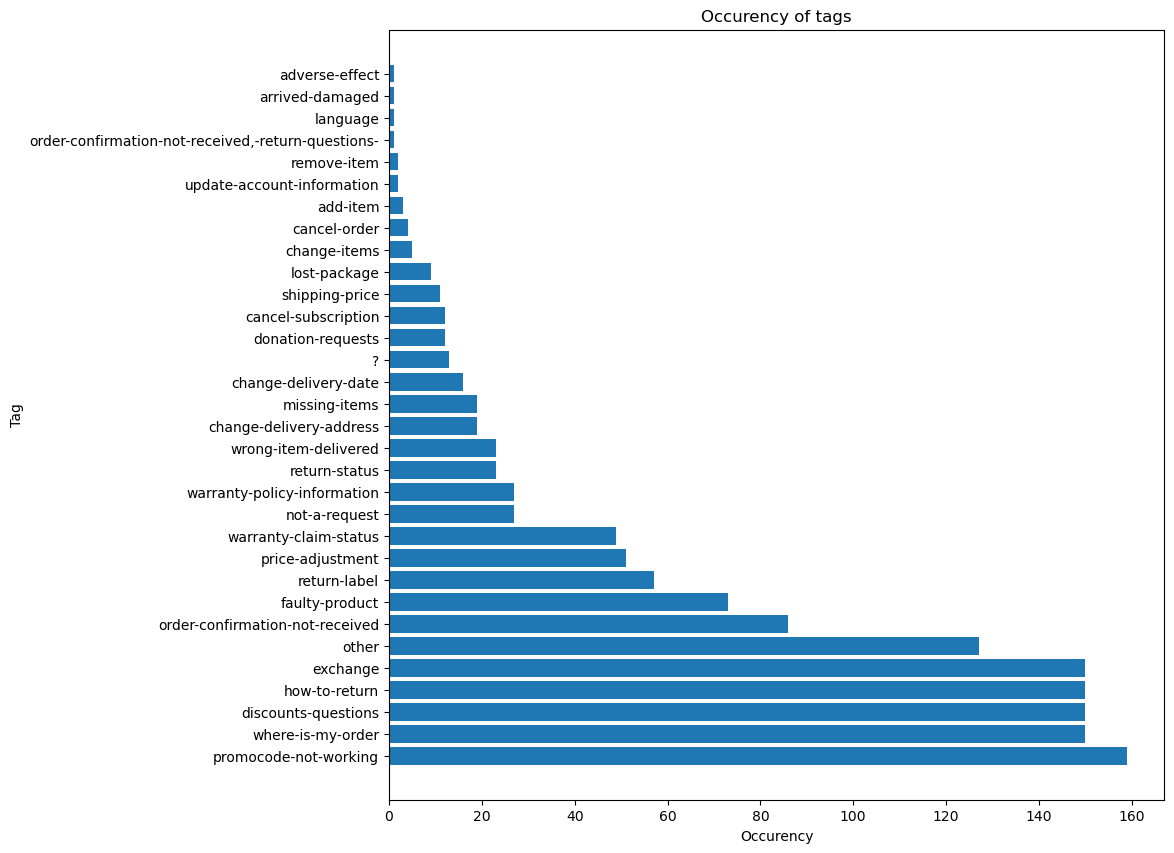

In [4]:
def visualize_data_set(tag_column) : 
    count_distinct_tags = tag_column.value_counts().to_dict()
    values = list(count_distinct_tags.values())
    keys = list(count_distinct_tags.keys())
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set(xlabel='Occurency',ylabel='Tag',title = 'Occurency of tags')
    bar_chart=ax.barh(keys,values)
    return bar_chart
bar_chart = visualize_data_set(df["tags"])


In [5]:
# data with new tags : 0 and 1
df['order_status'].value_counts().to_dict()

{0: 1178, 1: 255}

In [6]:
# First step pre-processing text for later analysis 
def preprocess_text(text):
    # remove punctuation
    text = text.replace(string.punctuation,'')
    # convert to lowercase
    text = text.lower()
    # tokenize text into words
    words = word_tokenize(text)
    return ' '.join(word for word in words if word.isalpha())

In [7]:
# plot word cloud for identifying the most significant words 
def plot_word_cloud(all_text):
    # Create a word cloud object
    all_text = all_text.lower()
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(all_text)
    # Plot the word cloud
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return None

In [8]:
def count_word_frequency(all_text):
    all_text = all_text.lower()
    words = all_text.split()
    # Count the frequency of each word
    word_freq = Counter(words)
    # Print the frequency of each word, sorted by frequency
    for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True):
        print(word, freq)
    return word_freq

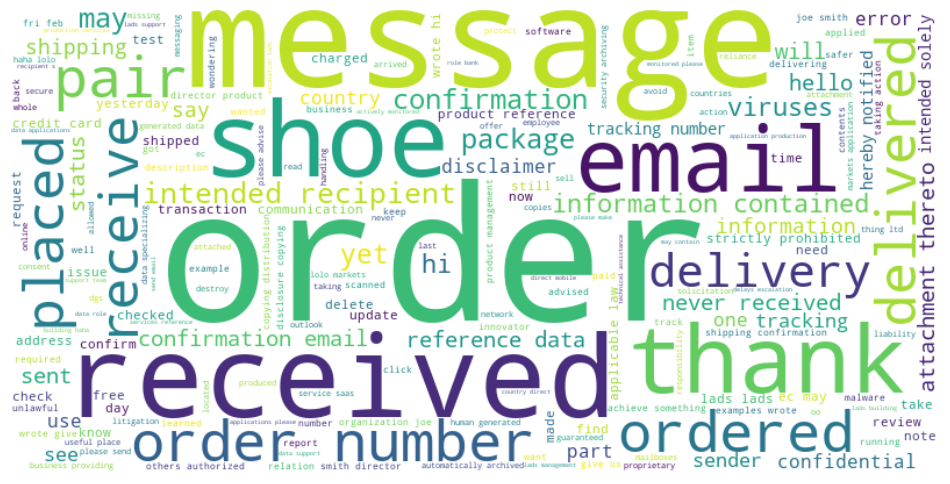

In [9]:
df_status_order = df[df['order_status']==1]
order_text = list(df_status_order['Description'])
all_text_order_status = ' '.join(order_text)
all_text_order_status = preprocess_text(all_text_order_status)
plot_word_cloud(all_text_order_status)

In [10]:
count_word_frequency(all_text_order_status)

the 731
i 583
and 571
to 461
of 397
order 348
you 342
this 321
is 313
or 310
for 296
a 281
in 277
my 267
have 233
an 214
not 211
any 202
on 195
message 190
it 180
that 177
please 153
received 151
be 148
email 144
may 139
are 135
was 131
by 122
can 117
confirmation 113
if 109
number 104
but 91
shoes 88
as 86
no 85
from 84
me 84
information 84
recipient 83
your 81
intended 79
lads 78
hi 75
with 73
at 70
been 69
sender 69
ordered 66
am 66
ec 65
delivery 64
they 60
has 58
tracking 57
never 56
delivered 56
placed 56
bucket 55
product 55
which 55
its 55
receive 54
what 53
do 53
viruses 53
data 53
get 52
review 52
law 52
pair 51
them 51
all 51
shipping 51
delete 48
package 45
thanks 43
so 43
yet 43
other 43
just 41
contained 41
thank 41
confidential 40
prohibited 40
through 40
country 40
would 39
reference 39
attachments 39
where 39
attachment 39
thereto 39
there 38
wrote 38
service 38
status 37
being 37
hello 36
http 36
sent 35
we 35
when 35
should 35
will 34
out 34
our 34
free 33
did 33
key

Counter({'hi': 75,
         'i': 583,
         'have': 233,
         'just': 41,
         'ordered': 66,
         'a': 281,
         'pair': 51,
         'of': 397,
         'and': 571,
         'put': 12,
         'the': 731,
         'relevant': 1,
         'code': 5,
         'for': 296,
         'free': 33,
         'bag': 3,
         'as': 86,
         'new': 11,
         'customer': 12,
         'received': 151,
         'trainers': 7,
         'but': 91,
         'no': 85,
         'will': 34,
         'this': 321,
         'be': 148,
         'sent': 35,
         'separately': 4,
         'seems': 4,
         'to': 461,
         'an': 214,
         'inefficient': 1,
         'system': 4,
         'or': 310,
         'was': 131,
         'oversight': 1,
         'kind': 10,
         'regards': 9,
         'am': 66,
         'missing': 13,
         'shoes': 88,
         'from': 84,
         'my': 267,
         'order': 348,
         'could': 22,
         'someone': 6,
         'p

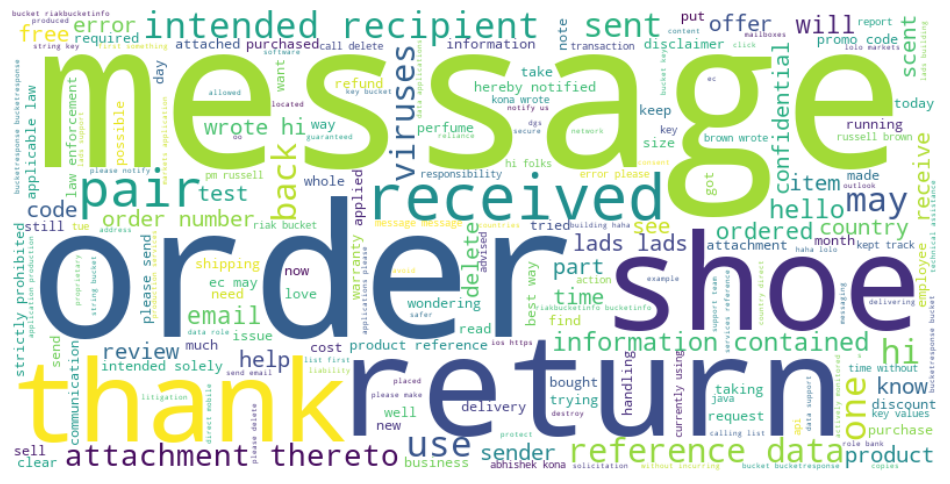

In [11]:
df_non_status_order = df[df['order_status']==0]
non_order_text = list(df_non_status_order['Description'])
all_text_non_order_status = ' '.join(non_order_text)
all_text_non_order_status = preprocess_text(all_text_non_order_status)
plot_word_cloud(all_text_non_order_status)

In [12]:
count_word_frequency(all_text_non_order_status)

the 4317
i 3893
and 3203
to 3027
of 2106
you 1895
a 1880
for 1815
this 1677
in 1637
is 1520
or 1449
my 1242
it 1193
that 1020
have 963
any 915
not 894
message 894
on 829
order 749
an 749
be 746
can 713
are 700
if 679
please 666
may 664
your 632
return 578
was 557
by 516
me 515
with 511
as 501
do 486
shoes 464
but 457
would 434
from 422
hi 422
am 416
like 394
received 385
at 379
intended 375
them 374
lads 372
recipient 371
code 364
email 363
information 345
product 343
get 330
bucket 320
so 319
sender 313
ec 310
which 298
no 295
all 287
send 272
its 267
they 266
what 264
been 262
pair 261
just 259
delete 258
law 257
one 254
out 253
back 252
review 251
viruses 250
data 248
other 241
thank 240
use 236
there 232
how 225
free 223
has 214
hello 213
thanks 213
number 195
http 193
key 192
wrote 191
time 191
reference 191
sent 190
country 190
attachment 189
confidential 187
attachments 187
contained 186
thereto 186
prohibited 185
through 180
discount 180
should 179
first 174
more 172
something 

Counter({'hello': 213,
         'i': 3893,
         'recently': 50,
         'purchased': 118,
         'my': 1242,
         'first': 174,
         'pair': 261,
         'of': 2106,
         'have': 963,
         'been': 262,
         'very': 93,
         'pleasantly': 1,
         'surprised': 6,
         'with': 511,
         'how': 225,
         'much': 80,
         'like': 394,
         'the': 4317,
         'ride': 2,
         'shoe': 110,
         'am': 416,
         'a': 1880,
         'and': 3203,
         'use': 236,
         'them': 374,
         'everyday': 4,
         'for': 1815,
         'training': 5,
         'unfortunately': 39,
         'flywire': 1,
         'on': 829,
         'one': 254,
         'shoes': 464,
         'snapped': 2,
         'other': 241,
         'day': 64,
         'pretty': 5,
         'bummed': 1,
         'because': 82,
         'they': 266,
         'seemed': 4,
         'to': 3027,
         'be': 746,
         'high': 9,
         'quality': 1

In [13]:
def count_phrase_frequency(text):
    # Tokenize the text into bigrams
    tokens = re.findall(r'\b\w+\b', text.lower())
    phrases = [' '.join(tokens[i:i+4]) for i in range(len(tokens)-1)]
    # Count the frequency of each phrase
    phrase_freq = Counter(phrases)
    # Print the frequency of each phrase, sorted by frequency
    for phrase, freq in sorted(phrase_freq.items(), key=lambda x: x[1], reverse=True):
        print(phrase, freq)
    return (phrase,freq)

In [14]:
count_phrase_frequency(all_text_non_order_status)

if you are not 186
the information contained in 185
you have received this 126
have received this message 124
received this message in 124
this message in error 124
is intended solely for 123
information contained in this 123
you are not the 123
recipient you are hereby 123
you are hereby notified 123
are hereby notified that 123
i would like to 93
what is the best 66
would like to return 66
is the best way 65
the best way to 65
if you have received 65
on pm russell brown 64
pm russell brown wrote 64
russell brown wrote hi 64
brown wrote hi on 64
wrote hi on tue 64
hi on tue at 64
on tue at abhishek 64
tue at abhishek kona 64
at abhishek kona wrote 64
abhishek kona wrote hi 64
kona wrote hi folks 64
wrote hi folks what 64
hi folks what is 64
folks what is the 64
best way to clear 64
way to clear a 64
to clear a riak 64
clear a riak bucket 64
a riak bucket of 64
riak bucket of all 64
bucket of all key 64
of all key values 64
all key values after 64
key values after running 64
values aft

dear customer representative i 1
customer representative i ordered 1
representative i ordered two 1
of shoes and an 1
shoes and an pack 1
and an pack last 1
an pack last night 1
pack last night on 1
last night on november 1
night on november and 1
on november and used 1
november and used the 1
promo code but did 1
code but did not 1
did not get promotion 1
not get promotion on 1
get promotion on the 1
promotion on the free 1
on the free can 1
the free can you 1
free can you look 1
can you look into 1
into this for me 1
this for me and 1
for me and let 1
know if you can 1
you can credit mefor 1
can credit mefor the 1
credit mefor the pack 1
mefor the pack if 1
the pack if not 1
pack if not i 1
if not i would 1
not i would like 1
to cancel the pack 1
cancel the pack off 1
the pack off order 1
pack off order number 1
off order number hello 1
number hello i received 1
i received the above 1
received the above delivery 1
the above delivery thank 1
above delivery thank you 1
delivery thank y

('thank you', 1)

In [15]:
count_phrase_frequency(all_text_order_status)

the information contained in 40
if you are not 40
information contained in this 27
is intended solely for 27
you are not the 27
recipient you are hereby 27
you are hereby notified 27
are hereby notified that 27
i placed an order 26
you have received this 26
have received this message 26
received this message in 26
this message in error 26
i have not received 22
ordered a pair of 19
i ordered a pair 17
received a confirmation email 15
on fri feb at 15
fri feb at am 15
feb at am examples 15
at am examples wrote 15
am examples wrote give 15
examples wrote give us 15
wrote give us an 15
give us an example 15
us an example of 15
an example of how 15
example of how you 15
of how you applied 15
how you applied what 15
you applied what they 15
applied what they learned 15
what they learned to 15
they learned to achieve 15
learned to achieve something 15
to achieve something in 15
achieve something in your 15
something in your organization 15
in your organization joe 15
your organization joe sm

('thank you', 1)

# Create new possible features for the model beside 'word frequency'

2 new features will be created: 

- New feature 1 : presence of specific keywords or phrases
- New feature 2 : sentiment analysis score

More detailed explaination: 

- New feature 1 : presence of specific keywords or phrases

    - New feature 1 created based on the word cloud, word count, phrase count in the previous steps. I define a list of important keywords, which will be used as feature vectors.
    - Define a list of relevant keywords or phrases that are indicative of the customer asking about order status or not with their order.
    - Assign a binary value (0 or 1) to each keyword or phrase to indicate whether it appears in the message text or not.
    - Aggregate the binary values for all keywords or phrases to create a feature vector for each message.
    
- New feature 2: sentiment analysis score

    - Use a pre-trained sentiment analysis tool or library like TextBlob or VADER to calculate the sentiment score of each email.
    - Sentiment analysis tools typically output a score between -1 (negative) and 1 (positive), indicating the overall sentiment of the text.
    - Use the sentiment score as a feature in the model, or discretize it into a binary value based on a pre-defined threshold.

In [16]:
# importan keywords
key_words=['track', 'tracking','ship','placed','inform',
          'return','discount','returning','refund','promo code', 'assistance','coupon','subscription','warranty',
          'technical assistance','damaged item','return process','please cancel','gift voucher','gift certificate', 'tracking information'
           'shipping cost','bucket operations','shipping label','free pack', 'been shipped','wrong address','what address','never received','not received',
           'customer service department', 'give me an update','avoid any delays', 'where is my order',
          'not been delivered','links for tracking','status of order','nothing was delivered','order never arrived','not yet received','not received an order',
          'what s going on','can t wait', 'didn t get my order','never was delivered','send me a tracking number']

# Define the sentiment analysis tool
analyzer = SentimentIntensityAnalyzer()

# Preprocess messages text
df['Description'] = df['Description'].apply(lambda row: preprocess_text(row))

# Calculate the presence features - Create a key phrase feature vector for each text sample
presence = np.zeros((len(df), len(key_words)))
for i, sample in enumerate(df):
    for j, phrase in enumerate(key_words):
        if phrase in sample.lower():
            presence[i, j] = 1

# Calculate the sentiment features
sentiment = []
for text in df['Description']:
    score = analyzer.polarity_scores(text)
    sentiment.append([score['compound']])
df['sentiment'] = sentiment


# Data cleaning 

Preprocess the data by cleaning and formatting the text:


    - Removing greetings and clossings of an email/message - which do not bring any information
    - Removing any unnecessary information like stop words, email addresses, dates, time urls,etc
    - Stemming and emmatizing

In [17]:
#1. Removing greetings and clossings of an email/message - which do not bring any information

def remove_greeting_closing(doc):
    greeting = ['hi', 'hey', 'hello', 'dear', 'greetings', 'hai', 'guys', 'hii', 'howdy', 'hiya', 'hay',
                'good morning','good afternoon','good evening','heya', 'hola', 'hihi', 'sir','madam']
    

    closing = [ 'regards', 'sincerely', 'best wishes', 'cheers', 'thanks in advance', 
               'thank you', 'thanks', 'take care', 'rgrds','yours truly', 'looking forward to hearing from you', 
               'have a blessed day','sent from my iphone','thank','kind']
    
    matcher.add('GREETING_CLOSING', [[{'LOWER': {'IN': greeting}}]])
    new_sents = []
    for sentence in doc.sents:
        sentence_text = sentence.text + ' '
        num_alpha_words = sum(1 for token in sentence if token.is_alpha)
        if matcher(sentence):
            for match_id,start,end in matcher(sentence):
                match_span = doc[start:end]
                if num_alpha_words <= 4:
                    break
                else:
                    sentence_text = sentence_text.replace(match_span.text, '')
                    new_sents.append(sentence_text)

        else:
            new_sents.append(sentence_text)
    text = ''.join(sent for sent in new_sents)
    text = text.replace('_',' ')
    for c in closing:
        index = text.lower().find(c)
        if index != -1:
            new_text = text[:index]
            my_list = new_text.split(' ')
            alpha_list = [element for element in my_list if any(char.isalpha() for char in element)]
            if len(alpha_list)> 5:
                text = new_text
                break
            else:
                text = text.replace(c,'')
                break
    return text.strip()

In [18]:
# 2. Removing any unnecessary information like email addresses, dates, time urls,etc
def extract_entities(doc):
    return [e.text for e in doc.ents if e.label_ in ("PER", "LOC", "DATE", "TIME", "ORG", "NORP", "GPE", "MONEY", "ORDINAL","PERCENT")]

def pre_processing(doc,stemmer):
    entities_to_remove = extract_entities(doc)
    tokens = [token.lemma_ for token in doc if
              token.is_alpha
               and len(token.text)>2
               and not token.is_punct
               and not token.is_currency
               and not token.is_digit
               and not token.like_email
               and not token.like_url
               and not token.is_space
               and not token.like_num
               and not token.is_stop
               and not token.pos_ == "PROPN"
               and not token.pos_ == "ADV"
] 
        
    clean_text = " ".join(stemmer.stem(token) for token in tokens if token not in entities_to_remove)
    return clean_text

In [19]:
# call funcs to clean text
clean_text,new_descriptions= [],[]
with nlp.disable_pipes('tagger','attribute_ruler', 'lemmatizer', 'ner'):
    for doc in nlp.pipe(df['Description']):
        new_descriptions.append(remove_greeting_closing(doc))
    
for doc in nlp.pipe(new_descriptions):
    clean_text.append(pre_processing(doc,stemmer))

In [21]:
# look at word frequency again after cleaning, so we can do some post-cleaning if its necesssary  
word_freq = count_word_frequency(' '.join(text for text in clean_text))

order 1360
messag 879
shoe 680
receiv 666
return 665
email 460
product 455
send 434
like 431
attach 397
pair 396
bucket 380
key 380
code 373
lad 330
intend 315
inform 301
number 299
recipi 297
law 284
delet 270
purchas 264
sender 264
viru 258
tri 256
use 254
time 237
run 236
confirm 228
review 227
ship 226
countri 226
applic 224
want 220
monitor 220
contain 219
free 218
write 214
notifi 207
discount 202
servic 200
place 196
error 192
track 190
good 184
deliv 175
refer 175
know 168
thereto 165
scent 165
deliveri 164
list 163
item 158
say 156
copi 156
way 155
test 154
get 151
confidenti 148
respons 147
take 146
help 146
need 145
offer 144
buy 138
month 133
size 132
advis 131
custom 129
day 124
request 123
support 122
week 121
wear 121
promo 120
warranti 120
prohibit 117
issu 117
employe 116
new 114
address 114
wonder 112
offici 112
go 111
produc 110
network 110
busi 109
dissemin 108
love 107
cost 105
archiv 105
commun 103
packag 103
appli 102
check 102
let 101
call 100
find 99
pay 99
act

# More post-cleaning 

In [22]:
# words that appear too often or too little, we can remove them
def remove_high_freq_words(text_list, word_counts, threshold_1, threshold_2):
    # Get a list of words to remove
    remove_words = [word for word, count in word_counts.items() if count > threshold_1 or count < threshold_2]
    # Remove high frequency words from the text
    clean_text_list = []
    for text in text_list:
        clean_text = ' '.join([word for word in text.split() if word not in remove_words])
        clean_text_list.append(clean_text)
    return clean_text_list

In [23]:
clean_text_new = remove_high_freq_words(clean_text,word_freq,300,3)

In [24]:
# Create a list of words to be removed
words_to_remove = ["mail",  "hello", "day", "month", "date", "think", "like","time","visa","etc","friend","mom",
                  "telephon", "http", "fax", "outlook", "mobil", "thereto", "bucketrespons", "string", "new", "network",
                  "mailbox", "io", "have", "wife","hours", "etc"]

# remove words from the text
def remove_words(text_list, words_to_remove):
    return [' '.join([word for word in sentence.split() if word.lower() not in words_to_remove]) for sentence in text_list]

clean_text_new = remove_words(clean_text_new, words_to_remove)


In [25]:
df["Description"] = clean_text_new

In [26]:
# find index of empty Description rows
empty_indices = df.index[df["Description"] == ''].tolist()
# remove the rows with the specified indices
df = df.drop(index=empty_indices).reset_index(drop=True)

In [27]:
# remove the rows with the specified indices
presence = np.delete(presence, empty_indices, axis=0)

In [28]:
# check null 
df.isnull().mean()

Description     0.0
tags            0.0
order_status    0.0
sentiment       0.0
dtype: float64

# Construct different ML models


1. Features vectorize
- Split the cleaned data into a training, validation and testing set.
    - Feature 1: word frequency
    
        use tfidf() to convert message text to numerical vector
    
        Some reasons why i choose Tfidf to vectorize text:
        - I do not use Word Embedding methods (CBOW, Skip-gram, Glove, FastText, BERT) because it is not necessary to capture the meaning of words and the relationships between words by using embedding techniques in this project. word embeddings can be computationally expensive to train and require large amounts of text data.  
        - Words embedding is more suitable for longer texts where capturing semantic relationships between words is important, while TF-IDF is more suitable for shorter texts. So, when it comes to short text classification, TF-IDF is often the preferred method for feature extraction.
        - I have also tested BoW but it did not bring good result as Tf-idf
    
    - Feature 2: Presence of specific keywords or phrases which has been saved in parameter 'presence'
    
    - Feature 3: Sentiment analysis score
        - I will not use sentiment analysis feature because after looking at sentiment analysis feature (calculated above), i dont see the correlation between this feature and output

2. Apply oversampling technique to balance training set



3. Model training, tuning and testing
- Use a supervised learning algorithm like Logistic Regression, Naive Bayes, Random Forest, Support Vector Machines (SVM) to train the model on the training set.
- Use Grid Search to search for the best combination of parameters 
- Use validation set to evaluate models, fine-tune its parameters to improve its accuracy
- Plot learning curve, use it to diagnose the model, to detect underfitting, overfitting and just-right condition
- Use the testing set to test the model's performance 

# 1. Features vectorize

In [47]:
# Split data into train and test sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(list(df['Description']), presence, list(df['order_status']), test_size = 0.2, random_state = 0)

# Initialize TfidfVectorizer object
vectorizer_X = TfidfVectorizer(ngram_range=(1,1),max_features=2000, min_df=0.008, max_df=0.9, stop_words = 'english')

# Fit the vectorizer to the training data and transform it into a matrix
X1_train_tfidf = vectorizer_X.fit_transform(X1_train)

# Transform the test data into a matrix
X1_test_tfidf = vectorizer_X.transform(X1_test)

# Get the vocabulary and IDF weights
vocab = vectorizer_X.vocabulary_
idf_weights = vectorizer_X.idf_

# Get the indices that sort the IDF weights in descending order
idx = np.argsort(idf_weights)[::-1]

print("length of the vocabulary used to create feature vector: ", len(vocab))
# Print the top N words with their IDF weights
'''
N = 50
for i in range(N):
    word = list(vocab.keys())[list(vocab.values()).index(idx[i])]
    weight = idf_weights[idx[i]]
    print(f"{word}: {weight:.3f}")
'''
    
# Concatenate the key phrase feature vector with the TF-IDF feature vector
combined_features_train = hstack([X1_train_tfidf,X2_train])
combined_features_test = hstack([X1_test_tfidf,X2_test])

# convert test data to np array
combined_features_test = combined_features_test.toarray()
y_test = np.array(y_test)

# Apply SMOTE to oversample training data on minority class 
smote = SMOTE(sampling_strategy=0.9,random_state=42)
combined_features_train, y_train = smote.fit_resample(combined_features_train, y_train)

# convert train data to np array
y_train = np.array(y_train)
combined_features_train = combined_features_train.toarray()

length of the vocabulary used to create feature vector:  376


# Model training, tuning and testing with traditional ML algos

In [48]:
models = [
    ("LogisticRegression", LogisticRegression()), #class_weight="balanced" 
    ("MNB", MultinomialNB()),
    ("BNB", BernoulliNB()),
    ("SVC", SVC()), 
    ("RF", RandomForestClassifier())
]

best_estimators = {}

for name, model in models:
    print(f"Training {name}")
    
    # Perform grid search for the model

    if name == "LogisticRegression":
        param_grid = {
            "solver": ["liblinear"], #'lbfgs', 'liblinear',  'newton-cholesky', "sag", "saga","newton-cg"
            "penalty": ["l1","l2"], #"none", 'l1','elasticnet'
            "C": [0.1,1] # giảm C tránh overfit
        }

    if name == "MNB":
        param_grid = {
            "alpha": [1.0e-10, 0.01, 0.1, 1]#0, 1e-05,  1e-03, 
        }
    if name == "BNB":
        param_grid = {
            "alpha": [1.0e-10, 0.01, 0.1, 1]#0, 1e-05, 1e-03, 
        }

    elif name == "SVC":
        param_grid = {
            "C": [1,10], # giảm c tránh overfit
            "kernel": ["linear"], #"poly", "rbf", "sigmoid"
            "degree": [1, 2, 3],
            "gamma":  [0.01, 0.1, 1, 10] #"scale", "auto",
        }
        
    elif name == "RF":
        param_grid = {
            "n_estimators": [5, 10], #100, 500
            "max_depth": [None, 10, 50, 100],
            "min_samples_split": [5, 10,20],
            "min_samples_leaf": [2, 4]
        }
    # Define the cross-validation scheme
    cv = KFold(n_splits=30, shuffle=True, random_state=42)
        
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1) #  scoring='f1'
    grid_search.fit(combined_features_train, y_train)
    
    # Save the best estimator
    best_estimators[name] = grid_search.best_estimator_
    
    # Print the best hyperparameters and corresponding accuracy
    print(f"Best hyperparameters: {grid_search.best_params_}")
    
    # Calculate accuracy on training set
    train_accuracy = best_estimators[name].score(combined_features_train, y_train)
    print(f" - Mean Accuracy on training set : {train_accuracy:.3f}")
    
    # Mean accuracy score of the best_estimator over all cross-validation folds
    print(f" - Mean Accuracy on Validation set: {grid_search.best_score_:.3f}")
    
    # Make predictions on the test set using the best estimator
    y_pred = best_estimators[name].predict(combined_features_test)
    acc = accuracy_score(y_test, y_pred)
    print(f" - Test accuracy: {acc:.3f}\n")
    


Training LogisticRegression
Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
 - Mean Accuracy on training set : 0.934
 - Mean Accuracy on Validation set: 0.919
 - Test accuracy: 0.897

Training MNB
Best hyperparameters: {'alpha': 1e-10}
 - Mean Accuracy on training set : 0.929
 - Mean Accuracy on Validation set: 0.919
 - Test accuracy: 0.844

Training BNB
Best hyperparameters: {'alpha': 1e-10}
 - Mean Accuracy on training set : 0.894
 - Mean Accuracy on Validation set: 0.888
 - Test accuracy: 0.848

Training SVC
Best hyperparameters: {'C': 10, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear'}
 - Mean Accuracy on training set : 0.976
 - Mean Accuracy on Validation set: 0.936
 - Test accuracy: 0.855

Training RF
Best hyperparameters: {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
 - Mean Accuracy on training set : 0.981
 - Mean Accuracy on Validation set: 0.937
 - Test accuracy: 0.872



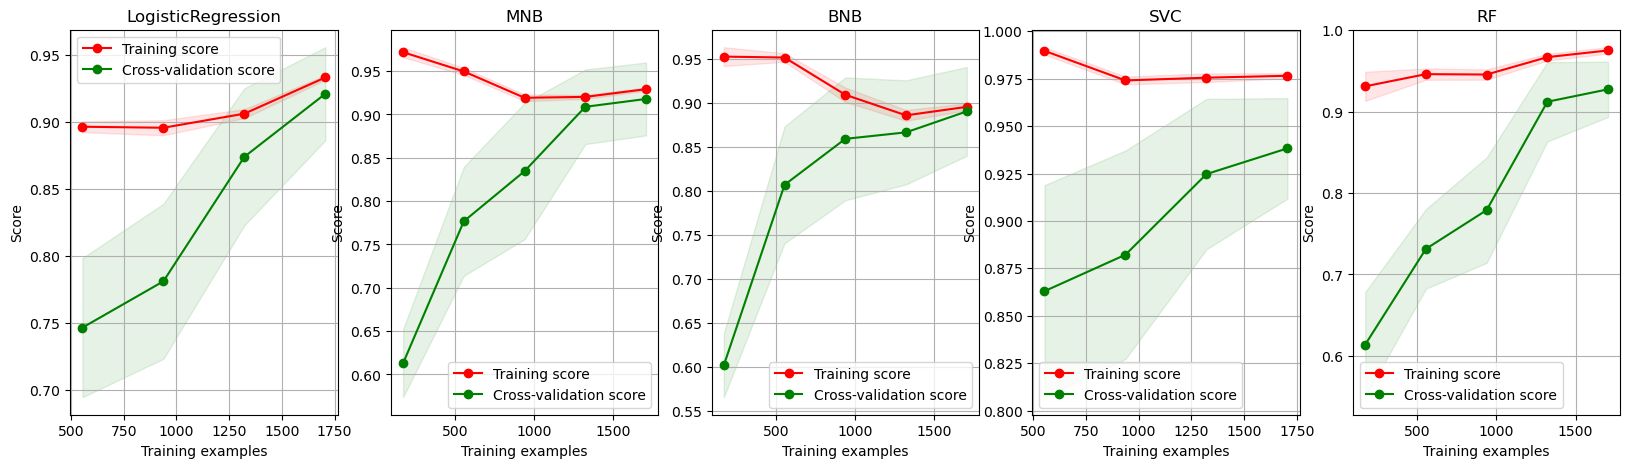

In [49]:
# Plot the learning curves for all models
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 5))

for idx, (name, model) in enumerate(models):
    estimator = best_estimators[name]
    # function trains the model on a sequence of increasing training set sizes and computes the training 
    #and test scores for each of these sizes
    cv = KFold(n_splits=30, shuffle=True, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, combined_features_train, y_train, cv=30, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax = axes[idx]
    ax.set_title(name)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid()
    
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                    color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.legend(loc="best")
plt.show()


# Neural Network model - Hyperparameter Tuning
use a more complex model- neural network

In [52]:
# Clear the TensorFlow graph and release memory
tf.keras.backend.clear_session()

tf.random.set_seed(1234)
model1 = models.Sequential()

model1.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(0.1)))
model1.add(layers.Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

  

model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define early stopping criteria
#early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model1.fit(
    combined_features_train,y_train,validation_split=0.33,
    batch_size=32,
    epochs=800
)

Epoch 1/800
37/37 [==============================] - 2s 14ms/step - loss: 11.6530 - accuracy: 0.5601 - val_loss: 11.1261 - val_accuracy: 0.0395
Epoch 2/800
37/37 [==============================] - 0s 7ms/step - loss: 10.6087 - accuracy: 0.7521 - val_loss: 10.1536 - val_accuracy: 0.0000e+00
Epoch 3/800
37/37 [==============================] - 0s 7ms/step - loss: 9.6582 - accuracy: 0.7860 - val_loss: 9.2692 - val_accuracy: 0.0000e+00
Epoch 4/800
37/37 [==============================] - 0s 6ms/step - loss: 8.7934 - accuracy: 0.7860 - val_loss: 8.4671 - val_accuracy: 0.0000e+00
Epoch 5/800
37/37 [==============================] - 0s 6ms/step - loss: 8.0055 - accuracy: 0.7860 - val_loss: 7.7404 - val_accuracy: 0.0000e+00
Epoch 6/800
37/37 [==============================] - 0s 7ms/step - loss: 7.2872 - accuracy: 0.7860 - val_loss: 7.0836 - val_accuracy: 0.0000e+00
Epoch 7/800
37/37 [==============================] - 0s 7ms/step - loss: 6.6321 - accuracy: 0.7860 - val_loss: 6.4907 - val_accur

Epoch 114/800
37/37 [==============================] - 0s 7ms/step - loss: 0.4162 - accuracy: 0.8646 - val_loss: 0.9958 - val_accuracy: 0.4322
Epoch 115/800
37/37 [==============================] - 0s 8ms/step - loss: 0.4137 - accuracy: 0.8621 - val_loss: 0.9660 - val_accuracy: 0.4648
Epoch 116/800
37/37 [==============================] - 0s 9ms/step - loss: 0.4121 - accuracy: 0.8655 - val_loss: 0.9644 - val_accuracy: 0.4700
Epoch 117/800
37/37 [==============================] - 0s 8ms/step - loss: 0.4103 - accuracy: 0.8706 - val_loss: 0.9722 - val_accuracy: 0.4683
Epoch 118/800
37/37 [==============================] - 0s 7ms/step - loss: 0.4085 - accuracy: 0.8689 - val_loss: 0.9592 - val_accuracy: 0.4803
Epoch 119/800
37/37 [==============================] - 0s 9ms/step - loss: 0.4066 - accuracy: 0.8714 - val_loss: 0.9517 - val_accuracy: 0.4837
Epoch 120/800
37/37 [==============================] - 0s 9ms/step - loss: 0.4047 - accuracy: 0.8731 - val_loss: 0.9377 - val_accuracy: 0.4991

37/37 [==============================] - 0s 7ms/step - loss: 0.2747 - accuracy: 0.9323 - val_loss: 0.5192 - val_accuracy: 0.7839
Epoch 229/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2748 - accuracy: 0.9315 - val_loss: 0.5163 - val_accuracy: 0.7925
Epoch 230/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2742 - accuracy: 0.9315 - val_loss: 0.5075 - val_accuracy: 0.7907
Epoch 231/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2726 - accuracy: 0.9315 - val_loss: 0.5184 - val_accuracy: 0.7822
Epoch 232/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2729 - accuracy: 0.9306 - val_loss: 0.4571 - val_accuracy: 0.8268
Epoch 233/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2736 - accuracy: 0.9315 - val_loss: 0.4700 - val_accuracy: 0.8130
Epoch 234/800
37/37 [==============================] - 0s 8ms/step - loss: 0.2747 - accuracy: 0.9340 - val_loss: 0.4897 - val_accuracy: 0.7993
Epoch 235/800

37/37 [==============================] - 0s 7ms/step - loss: 0.2202 - accuracy: 0.9501 - val_loss: 0.3687 - val_accuracy: 0.8662
Epoch 343/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2194 - accuracy: 0.9526 - val_loss: 0.4448 - val_accuracy: 0.8062
Epoch 344/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2202 - accuracy: 0.9552 - val_loss: 0.3486 - val_accuracy: 0.8799
Epoch 345/800
37/37 [==============================] - 0s 8ms/step - loss: 0.2201 - accuracy: 0.9518 - val_loss: 0.3465 - val_accuracy: 0.8971
Epoch 346/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2199 - accuracy: 0.9501 - val_loss: 0.4237 - val_accuracy: 0.8130
Epoch 347/800
37/37 [==============================] - 0s 7ms/step - loss: 0.2193 - accuracy: 0.9560 - val_loss: 0.3817 - val_accuracy: 0.8559
Epoch 348/800
37/37 [==============================] - 0s 9ms/step - loss: 0.2192 - accuracy: 0.9475 - val_loss: 0.3892 - val_accuracy: 0.8525
Epoch 349/800

37/37 [==============================] - 0s 8ms/step - loss: 0.1902 - accuracy: 0.9653 - val_loss: 0.3331 - val_accuracy: 0.8731
Epoch 457/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1888 - accuracy: 0.9662 - val_loss: 0.3501 - val_accuracy: 0.8679
Epoch 458/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1914 - accuracy: 0.9611 - val_loss: 0.3369 - val_accuracy: 0.8714
Epoch 459/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1898 - accuracy: 0.9628 - val_loss: 0.2858 - val_accuracy: 0.9091
Epoch 460/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1889 - accuracy: 0.9594 - val_loss: 0.3265 - val_accuracy: 0.8782
Epoch 461/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.9653 - val_loss: 0.3355 - val_accuracy: 0.8714
Epoch 462/800
37/37 [==============================] - 0s 6ms/step - loss: 0.1893 - accuracy: 0.9636 - val_loss: 0.3051 - val_accuracy: 0.8971
Epoch 463/800

37/37 [==============================] - 0s 8ms/step - loss: 0.1712 - accuracy: 0.9704 - val_loss: 0.3025 - val_accuracy: 0.8902
Epoch 571/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1685 - accuracy: 0.9738 - val_loss: 0.3089 - val_accuracy: 0.8902
Epoch 572/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1712 - accuracy: 0.9662 - val_loss: 0.2347 - val_accuracy: 0.9503
Epoch 573/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1685 - accuracy: 0.9721 - val_loss: 0.2746 - val_accuracy: 0.9039
Epoch 574/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1688 - accuracy: 0.9687 - val_loss: 0.2237 - val_accuracy: 0.9623
Epoch 575/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1675 - accuracy: 0.9738 - val_loss: 0.2766 - val_accuracy: 0.9074
Epoch 576/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1675 - accuracy: 0.9729 - val_loss: 0.3225 - val_accuracy: 0.8868
Epoch 577/800

37/37 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9763 - val_loss: 0.2724 - val_accuracy: 0.8954
Epoch 685/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1546 - accuracy: 0.9738 - val_loss: 0.2370 - val_accuracy: 0.9211
Epoch 686/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1532 - accuracy: 0.9755 - val_loss: 0.2178 - val_accuracy: 0.9485
Epoch 687/800
37/37 [==============================] - 0s 8ms/step - loss: 0.1518 - accuracy: 0.9755 - val_loss: 0.2535 - val_accuracy: 0.9177
Epoch 688/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1541 - accuracy: 0.9746 - val_loss: 0.2584 - val_accuracy: 0.9228
Epoch 689/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1554 - accuracy: 0.9721 - val_loss: 0.2030 - val_accuracy: 0.9520
Epoch 690/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1571 - accuracy: 0.9712 - val_loss: 0.2319 - val_accuracy: 0.9520
Epoch 691/800

37/37 [==============================] - 0s 8ms/step - loss: 0.1437 - accuracy: 0.9788 - val_loss: 0.2323 - val_accuracy: 0.9228
Epoch 799/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 0.9746 - val_loss: 0.2205 - val_accuracy: 0.9331
Epoch 800/800
37/37 [==============================] - 0s 7ms/step - loss: 0.1419 - accuracy: 0.9772 - val_loss: 0.2367 - val_accuracy: 0.9211


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


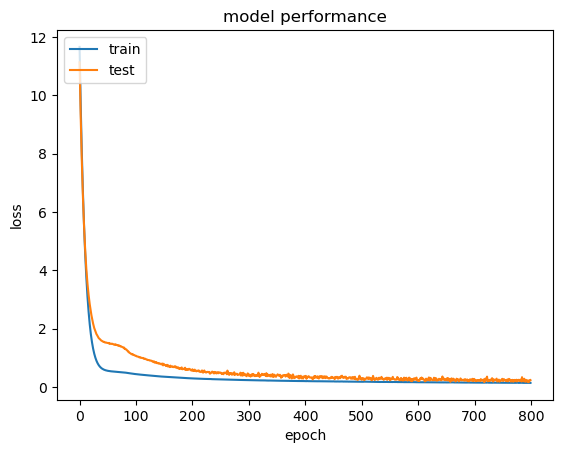

In [53]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
# Predict x_test using the trained model
y_pred = model1.predict(combined_features_test)

# Convert predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy for test set
test_accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on test set: {test_accuracy:.4f}")


9/9 [==============================] - 0s 2ms/step
Accuracy on test set: 0.8901


# Conclusion

After experimenting and fine-tuning several models, I draw the following conclusions:

1. Neural network requires a large amount of training data to perform well.


2.  In contrast, Traditional Machine Learning algorithms are simpler models that requires less data to train and can perform almost same result as NN.
- I have tried knn, knn is fast training but not suitable for our large dimensional data 
- LogisticRegression model has the best generalization performance on new data.
- Multinomial Naive Bayes and Bernouli Naive Bayes are mostly use in text classification. I ended up with 'alpha' parameter value = a very small number to overcome underfitting
- Looking at learning curve of SVC and RF models, we can say that if the model is trained on a larger data set, they can yield a better result.

3. The final models that I choose to export are LogisticRegression() and MultinomialNB()

# Export the last models 

In [58]:
mnb = best_estimators["MNB"]
lg = best_estimators["LogisticRegression"]

# Save the final model to a pickle file
with open("mnb_model.pkl", "wb") as f:
    pickle.dump(mnb, f)
with open("lg_model.pkl", "wb") as f:
    pickle.dump(mnb, f)